# Comparing Algorithms

Algorithms:
- Guarded-Hope ($\alpha=1$)
- PPA ($\alpha=\infty$)
- Greedy
- MaxDemand

Independent Variables:
- Aversion to Inequity $\alpha$
- Number of agents $n$
- Arrival order $t$
- Coefficient of Variation

Dependent Variables:
- Expected Social Welfare
- Expected Waste
- Expected Minimum Fill Rate
- Expected Maximum Distance to Optimal Hindsight
- Expected Max Envy

Data Settings:
- FBST
- Discrete Gaussian
- Discrete Gamma
- Discrete Exponential (light tailed)
- Discrete Pareto (heavy tailed)

In [16]:
import sys
import random

# add library to path (or else, src not visible)
sys.path.insert(0, "../../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from src.AllocationSolver import AllocationSolver
from src.dists import SymmetricDiscreteDistribution, Distribution, UniformDistribution, NormalDistribution
from src.plots import plot_against_algos, plot_against_alpha, plot_versus_alpha, map_algo_to_name, map_algo_to_color
from src.monte_carlo import hoeffding_bound
from src.format_data import clean_data

# use seaborn style plotting for poster presentation
sns.set_context("talk")
sns.set_style("whitegrid")

## Mobile Food Pantries

We have 70 demand locations, model with Normal demands.

In [17]:
data = clean_data(pd.read_excel("../../data/mfp_food_pantries.xlsx"))

# create demand distributions
demand_dists = [NormalDistribution(mu, sigma) for mu, sigma in zip(data["avg_demand"], data["std_demand"])]
n = hoeffding_bound(0.01, 0.01)

In [18]:
prob = AllocationSolver(
    demand_distributions=demand_dists,
    initial_supply=sum(demand_dists[i].mean() for i in range(len(demand_dists))),
    alpha=1,
    allocation_method="saffe"
)

### Expected Waste vs. $\alpha$

In [19]:
prob.change_allocation_method('ppa')
prob.monte_carlo_performance_metrics_batched(1000)

{'social_welfare': 0.9885052511663676,
 'waste': 109.40503625763081,
 'min_fill': 0.9276738486399164,
 'max_dist': 15.54066028408752,
 'max_envy': 0.07228471759398171}

In [20]:
# random.seed(1)
# np.random.seed(1)

# n = hoeffding_bound(0.1, 0.01)

# def generator(alpha):
#     prob.change_alpha(alpha)
#     prob.change_allocation_method("lambda_time")
#     prob.optimize_lambda(tol=0.1, monte_carlo=True, batch=True, batch_size=2048)
#     return prob.monte_carlo_performance_metrics_batched(n, batch_size=2048)['waste']

# plot_versus_alpha(generator, x_lab=rf"$\alpha$", y_lab="Expected Waste", title=rf"Expected Waste vs. $\alpha$")

# algos = ["ppa", "greedy", "saffe"]
# wastes = {
#     "ppa": 108,
#     "greedy": 92,
#     "saffe": 131
# }

# for algo in algos:
#     prob.change_allocation_method(algo)
#     avg_waste = wastes[algo]
#     plt.axhline(xmax=0, xmin=10, y=avg_waste, label=map_algo_to_name[algo], color=map_algo_to_color[algo])

# plt.legend()

## High/Low Demand, Scales with $N$

$N$ agents with High/Low demand, 2 support points Uniform{1, 2}, and coefficient of variation 0.2. Set the initial supply equal to the expected demand.

In [21]:
random.seed(0)
np.random.seed(0)

N = np.arange(2, 15)
optimal_dp = []
saffe = []
greedy = []
ppa = []
ppa_af = []

for i in tqdm(range(N.min(), N.max() + 1)):
    demand_dists = [Distribution((1, 2), (0.5, 0.5)) for _ in range(i)]

    prob = AllocationSolver(
        demand_distributions=demand_dists,
        initial_supply=i,
        alpha=0.5,
        allocation_method="exact"
    )
    prob.change_allocation_method("saffe")
    saffe.append(prob.solve()[0])
    prob.change_allocation_method("ppa")
    ppa.append(prob.solve()[0])
    prob.change_allocation_method("lambda_time")
    prob.optimize_lambda()
    ppa_af.append(prob.solve()[0])



  0%|          | 0/13 [00:00<?, ?it/s]/Users/dawsonren/Desktop/Research/alpha-fair-dynamic-allocation/src/experiments/../../src/metrics.py:31: RuntimeWarning: invalid value encountered in power
  demand_times_utility = demands * np.power(utilities, 1 - alpha)
100%|██████████| 13/13 [01:19<00:00,  6.13s/it]


Text(0.5, 1.0, 'Expected Social Welfare vs. Number of Agents for $\\alpha=\\frac{1}{2}$')

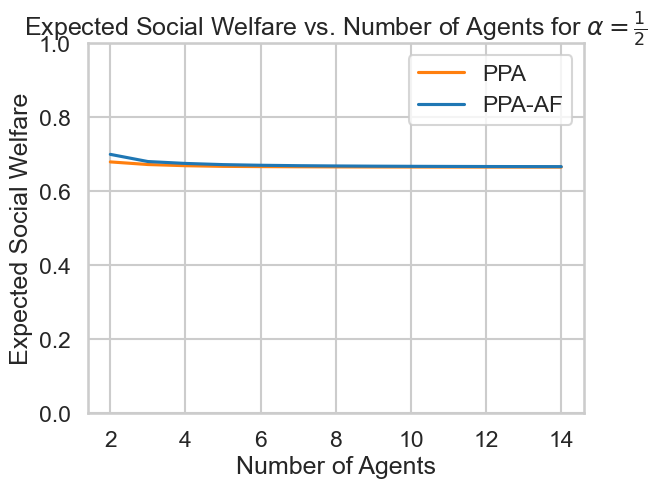

In [23]:
# plt.plot(N, saffe, label="SAFFE", color=map_algo_to_color["saffe"])
# plt.plot(N, greedy[4:], label="Greedy", color=map_algo_to_color["greedy"])
plt.plot(N, ppa, label="PPA", color=map_algo_to_color["ppa"])
plt.plot(N, ppa_af, label="PPA-AF", color=map_algo_to_color["lambda_time"])
plt.legend()
plt.xlabel("Number of Agents")
plt.ylim(0, 1)
plt.ylabel(r"Expected Social Welfare")
plt.title(r"Expected Social Welfare vs. Number of Agents for $\alpha=\frac{1}{2}$")